# Agrupamento de Dados do banco de dados sintéticos

Autores: Natanael Junior (natmourajr@lps.ufrj.br), Vinicius Mello (viniciusdsmello@poli.ufrj.br) e Pedro Lisboa (pedrohblisboa@gmail.com)

LPS - Laboratório de Processamento de Sinais
<center><img src="../data/logo_lps.jpg"></center>

In [1]:
%time
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


### Geração de dados sintéticos

In [2]:
%time
n_events = 1000

# dados em 45^o
angle = np.pi/6
rotation_matrix = [[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]]

m_means = [-0.2,0.2]
m_vars = [0.5,0.05]

data_c1 = m_vars*np.random.randn(n_events,2)+m_means
data_c1 = np.inner(data_c1,rotation_matrix)

m_means = [0.2,-0.2]
m_vars = [0.5,0.05]

data_c2 = m_vars*np.random.randn(n_events,2)+m_means
data_c2 = np.inner(data_c2,rotation_matrix)

data = np.append(data_c1, data_c2,axis=0)
trgt = np.append(1*np.ones(data_c1.shape[0]),2*np.ones(data_c2.shape[0]),axis=0)

df1 = pd.DataFrame()
df1['x1'] = data[:,0]
df1['x2'] = data[:,1]
df1['class'] = trgt

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [3]:
df1.head(10)

,x1,x2,class
0,-0.469584,0.012835,1.0
1,-0.629002,-0.261560,1.0
2,-0.703357,-0.147243,1.0
3,-0.645243,-0.089831,1.0
4,0.595642,0.492654,1.0
5,0.197985,0.389929,1.0
6,-0.240844,0.096961,1.0
7,-0.212658,0.122131,1.0
8,-0.990870,-0.261165,1.0
9,-0.476823,-0.111434,1.0


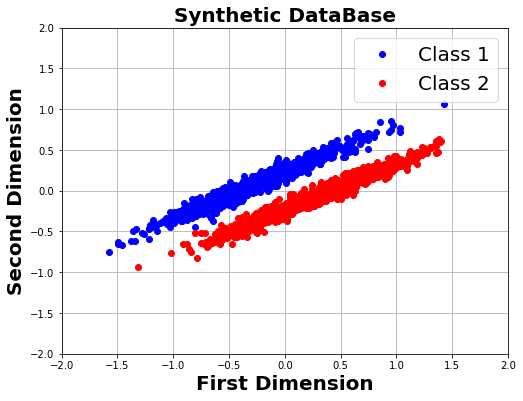

In [4]:
# plot data
%matplotlib inline  

fig = plt.figure(figsize=(8,6))

plt.plot(df1[df1['class']==1.]['x1'],df1[df1['class']==1.]['x2'],'bo',label='Class 1')
plt.plot(df1[df1['class']==2.]['x1'],df1[df1['class']==2.]['x2'],'ro',label='Class 2')

plt.legend()
plt.grid()
plt.title('Synthetic DataBase',fontweight='bold',fontsize=20)
plt.xlabel('First Dimension',fontweight='bold',fontsize=20)
plt.ylabel('Second Dimension',fontweight='bold',fontsize=20)
limits = [-2, 2]
plt.xlim(limits)
plt.ylim(limits)
plt.legend(fontsize=20)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_fin(data, predictions, cluster_centers):
    # compute Fi
    n_clusters = np.unique(predictions).shape[0]
    #print(n_clusters)
    class_labels  = np.unique(predictions)
    Fi = np.zeros([n_clusters,1])
    
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fi[icluster] = np.sum((data_norm[predictions==class_labels[icluster]] - 
                              cluster_centers[icluster])**2)
    Fin = np.sum(Fi)
    return Fin, Fi

def calculate_fout(data, predictions, cluster_centers):
    # compute center
    bari = np.mean(data,axis=0)
    n_clusters = np.unique(predictions).shape[0]
    class_labels  = np.unique(predictions)
    Fout = 0
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fout = Fout + np.sum((cluster_centers[icluster]-bari)**2)
    
    return Fout

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

nfolds = 10
foldshandler = StratifiedKFold(n_splits=nfolds)

nclusters = list(range(1,50))
Fin = np.zeros([len(nclusters),nfolds])
Fout= np.zeros_like(Fin)

for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt)):
    if ifold != 0: continue
    #print(ifold,trainId, testId)
    data_scaler = StandardScaler().fit(data[trainId])
    data_norm = data_scaler.transform(data)
    #data_norm = data
    
    for icluster in nclusters:
        kmeans = KMeans(n_clusters=icluster, random_state=0).fit(data_norm)
    
        predictions = kmeans.predict(data_norm)
        cluster_centers = kmeans.cluster_centers_
        Fin[icluster-1, ifold], Fi = calculate_fin(data_norm, predictions, cluster_centers)
        Fout[icluster-1, ifold] = calculate_fout(data_norm, predictions, cluster_centers)

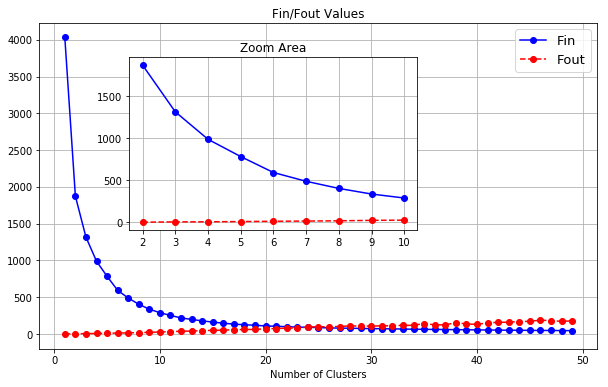

In [7]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)

ax.plot(nclusters,Fin[:,0],'o-',color='blue', label='Fin')
ax.plot(nclusters,Fout[:,0],'o--',color='red', label='Fout')
ax.grid()
ax.set_title('Fin/Fout Analysis')
ax.set_xlabel('Number of Clusters')
ax.set_title('Fin/Fout Values')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='best', fontsize=13,  markerscale=1., scatterpoints=1,)
rect = [0.2,0.2,0.7,0.7]
ax1 = plt.axes([.25, .4, .4, .4], facecolor='w')
ax1.plot(nclusters[1:10],Fin[1:10,0],'o-',color='blue', label='Fin')
ax1.plot(nclusters[1:10],Fout[1:10,0],'o--',color='red', label='Fout')
ax1.grid()
ax1.set_title('Zoom Area');


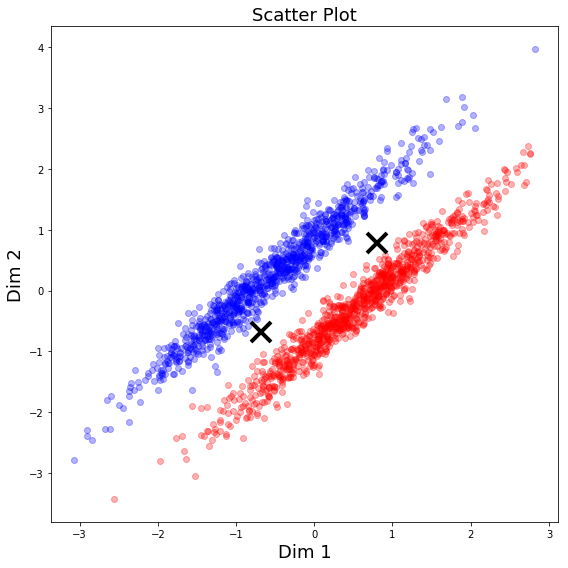

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

m_colors = ['b','r']
font_size = 18

trainId,testId = list(foldshandler.split(data,trgt))[0]
data_scaler = StandardScaler().fit(data[trainId])
data_norm = data_scaler.transform(data)

nclusters = 2
nclasses = np.unique(trgt).shape[0]

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data_norm)
predicted_data = kmeans.predict(data_norm)
predicted_classes = np.unique(predicted_data)

# painting clusters
mat_cluster_class = np.zeros([nclasses,nclusters])
for idx,iclass in enumerate(np.unique(trgt)):
    for iclus in range(nclusters):
        eff = 100.*(float(np.sum(predicted_data[trgt==iclass]==iclus))
                    /float(np.sum(trgt==iclass)))
        mat_cluster_class[idx,iclus] = eff
# choose most prob class in each cluster
mop_class = np.argmax(mat_cluster_class,axis=0)


fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(data_norm[trgt==1,0],data_norm[trgt==1,1],'o',alpha=0.3,color=m_colors[0])
ax.plot(data_norm[trgt==2,0],data_norm[trgt==2,1],'o',alpha=0.3,color=m_colors[1])

for iclus in range(nclusters):
    ax.plot(kmeans.cluster_centers_[iclus][0],
            kmeans.cluster_centers_[iclus][1],
            'x',markeredgecolor='black',#m_colors[mop_class[iclus]],
            markersize=20,mew=4)
            
ax.set_title('Scatter Plot', fontsize=font_size)
ax.set_xlabel('Dim 1',fontsize=font_size)
ax.set_ylabel('Dim 2',fontsize=font_size)
plt.tight_layout()

In [9]:
kmeans.cluster_centers_

array([[ 1.30056257,  1.28298297],
       [-1.141357  , -1.06877619],
       [-0.33080999,  0.50664917],
       [ 0.4908075 , -0.32230483]])

In [15]:
%time
n_events = 1000

# dados em 45^o
angle = np.pi/6
rotation_matrix = [[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]]

m_means = [-1,1]
m_vars = [0.5,0.5]

data_c1 = m_vars*np.random.randn(n_events,2)+m_means
data_c1 = np.inner(data_c1,rotation_matrix)

m_means = [1,-1]
m_vars = [0.5,0.5]

data_c2 = m_vars*np.random.randn(n_events,2)+m_means
data_c2 = np.inner(data_c2,rotation_matrix)

data = np.append(data_c1, data_c2,axis=0)
trgt = np.append(1*np.ones(data_c1.shape[0]),2*np.ones(data_c2.shape[0]),axis=0)

df1 = pd.DataFrame()
df1['x1'] = data[:,0]
df1['x2'] = data[:,1]
df1['class'] = trgt

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


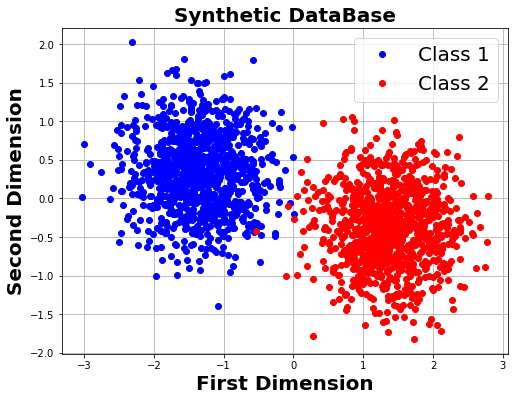

In [18]:
# plot data
%matplotlib inline  

fig = plt.figure(figsize=(8,6))

plt.plot(df1[df1['class']==1.]['x1'],df1[df1['class']==1.]['x2'],'bo',label='Class 1')
plt.plot(df1[df1['class']==2.]['x1'],df1[df1['class']==2.]['x2'],'ro',label='Class 2')

plt.legend()
plt.grid()
plt.title('Synthetic DataBase',fontweight='bold',fontsize=20)
plt.xlabel('First Dimension',fontweight='bold',fontsize=20)
plt.ylabel('Second Dimension',fontweight='bold',fontsize=20)
#limits = [-2, 2]
#plt.xlim(limits)
#plt.ylim(limits)
plt.legend(fontsize=20)

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

nfolds = 10
foldshandler = StratifiedKFold(n_splits=nfolds)

nclusters = list(range(1,50))
Fin = np.zeros([len(nclusters),nfolds])
Fout= np.zeros_like(Fin)

for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt)):
    if ifold != 0: continue
    #print(ifold,trainId, testId)
    data_scaler = StandardScaler().fit(data[trainId])
    data_norm = data_scaler.transform(data)
    #data_norm = data
    
    for icluster in nclusters:
        kmeans = KMeans(n_clusters=icluster, random_state=0).fit(data_norm)
    
        predictions = kmeans.predict(data_norm)
        cluster_centers = kmeans.cluster_centers_
        Fin[icluster-1, ifold], Fi = calculate_fin(data_norm, predictions, cluster_centers)
        Fout[icluster-1, ifold] = calculate_fout(data_norm, predictions, cluster_centers)

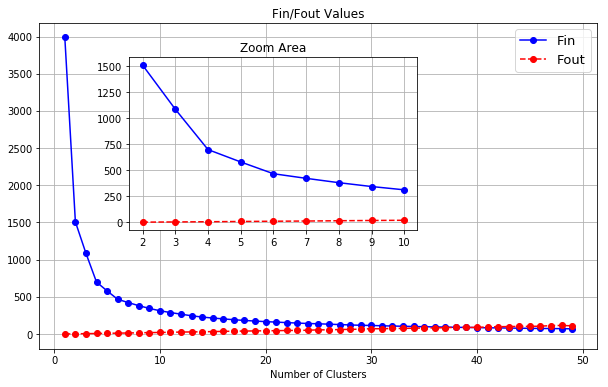

In [20]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)

ax.plot(nclusters,Fin[:,0],'o-',color='blue', label='Fin')
ax.plot(nclusters,Fout[:,0],'o--',color='red', label='Fout')
ax.grid()
ax.set_title('Fin/Fout Analysis')
ax.set_xlabel('Number of Clusters')
ax.set_title('Fin/Fout Values')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='best', fontsize=13,  markerscale=1., scatterpoints=1,)
rect = [0.2,0.2,0.7,0.7]
ax1 = plt.axes([.25, .4, .4, .4], facecolor='w')
ax1.plot(nclusters[1:10],Fin[1:10,0],'o-',color='blue', label='Fin')
ax1.plot(nclusters[1:10],Fout[1:10,0],'o--',color='red', label='Fout')
ax1.grid()
ax1.set_title('Zoom Area');


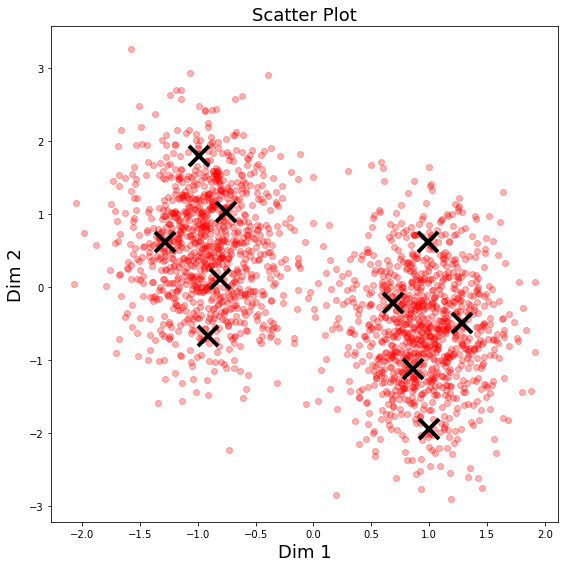

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

m_colors = ['b','r']
font_size = 18

trainId,testId = list(foldshandler.split(data,trgt))[0]
data_scaler = StandardScaler().fit(data[trainId])
data_norm = data_scaler.transform(data)

nclusters = 10
nclasses = np.unique(trgt).shape[0]

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data_norm)
predicted_data = kmeans.predict(data_norm)
predicted_classes = np.unique(predicted_data)

# painting clusters
mat_cluster_class = np.zeros([nclasses,nclusters])
for idx,iclass in enumerate(np.unique(trgt)):
    for iclus in range(nclusters):
        eff = 100.*(float(np.sum(predicted_data[trgt==iclass]==iclus))
                    /float(np.sum(trgt==iclass)))
        mat_cluster_class[idx,iclus] = eff
# choose most prob class in each cluster
mop_class = np.argmax(mat_cluster_class,axis=0)


fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(data_norm[trgt==1,0],data_norm[trgt==1,1],'o',alpha=0.3,color=m_colors[1])
ax.plot(data_norm[trgt==2,0],data_norm[trgt==2,1],'o',alpha=0.3,color=m_colors[1])

for iclus in range(nclusters):
    ax.plot(kmeans.cluster_centers_[iclus][0],
            kmeans.cluster_centers_[iclus][1],
            'x',markeredgecolor='black',#m_colors[mop_class[iclus]],
            markersize=20,mew=4)
            
ax.set_title('Scatter Plot', fontsize=font_size)
ax.set_xlabel('Dim 1',fontsize=font_size)
ax.set_ylabel('Dim 2',fontsize=font_size)
plt.tight_layout()

In [30]:
kmeans.cluster_centers_

array([[ 0.8593133 , -1.12091246],
       [-1.28202591,  0.618992  ],
       [ 1.28134883, -0.50194087],
       [-0.91553319, -0.67155945],
       [-0.75625427,  1.03061981],
       [ 1.00327715, -1.95199857],
       [ 0.99325514,  0.61353598],
       [-0.80458096,  0.11386954],
       [ 0.68591893, -0.22483406],
       [-0.99086842,  1.79747717]])